<a href="https://colab.research.google.com/github/jonasrauber/foolbox-native-tutorial/blob/master/foolbox-native-tutorial.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Activate GPU

1.   Runtime menu
2.   Change runtime type
3.   Hardware accelerator -> GPU

## Get Foolbox

In [5]:
!pip3 install foolbox==3.1.1
# !pip3 install git+https://github.com/bethgelab/foolbox.git

     |████████████████████████████████| 1.7MB 7.4MB/s 
     |████████████████████████████████| 61kB 10.1MB/s 
     |████████████████████████████████| 174kB 51.5MB/s 
     |████████████████████████████████| 71kB 11.3MB/s 
ERROR: google-colab 1.0.0 has requirement requests~=2.23.0, but you'll have requests 2.25.1 which is incompatible.
ERROR: datascience 0.10.6 has requirement folium==0.2.1, but you'll have folium 0.8.3 which is incompatible.
  Found existing installation: requests 2.23.0
    Uninstalling requests-2.23.0:
      Successfully uninstalled requests-2.23.0


In [6]:
import foolbox as fb

In [7]:
import torch
import torchvision

In [8]:
torch.__version__

'1.9.0+cu102'

In [9]:
torch.cuda.is_available()

True

In [10]:
model = torchvision.models.resnet50(pretrained=True)

Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth


In [11]:
model = model.eval()

## Turn your PyTorch model into a Foolbox model


In [12]:
# PyTorch ResNet50
preprocessing = dict(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225], axis=-3)
bounds = (0, 1)
fmodel = fb.PyTorchModel(model, bounds=bounds, preprocessing=preprocessing)

## Transform bounds

In the following, we want to work with a model that has `(0, 1)` bounds. Use `fmodel.transform_bounds`.

In [13]:
fmodel = fmodel.transform_bounds((0, 1))

In [14]:
assert fmodel.bounds == (0, 1)

## Get some test images

Get a batch of 16 images and the corrresponding labels. You can use `foolbox.utils.samples` to get up to 20 images, but you can also you your own data loader.

In [15]:
images, labels = fb.utils.samples(fmodel, dataset='imagenet', batchsize=16)

## Check the accuracy of your model to make sure you specified the correct preprocessing

In [16]:
fb.utils.accuracy(fmodel, images, labels)

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


0.9375

In [17]:
type(images), images.shape

(torch.Tensor, torch.Size([16, 3, 224, 224]))

In [18]:
type(labels), labels.shape

(torch.Tensor, torch.Size([16]))

## Run LinfDeepFool

In [19]:
attack = fb.attacks.LinfDeepFoolAttack()

In [20]:
raw, clipped, is_adv = attack(fmodel, images, labels, epsilons=0.03)

In [21]:
is_adv

tensor([True, True, True, True, True, True, True, True, True, True, True, True,
        True, True, True, True], device='cuda:0')

## Use EagerPy tensors and rerun the attack

In [22]:
import eagerpy as ep

In [23]:
images = ep.astensor(images)
labels = ep.astensor(labels)

In [24]:
raw, clipped, is_adv = attack(fmodel, images, labels, epsilons=0.03)

In [25]:
is_adv

PyTorchTensor(tensor([True, True, True, True, True, True, True, True, True, True, True, True,
                      True, True, True, True], device='cuda:0'))

In [26]:
is_adv.float32().mean().item()

1.0

## Using the Misclassification criterion explicitly

In [27]:
criterion = fb.criteria.Misclassification(labels)

In [28]:
raw, clipped, is_adv = attack(fmodel, images, criterion, epsilons=0.03)

In [29]:
is_adv

PyTorchTensor(tensor([True, True, True, True, True, True, True, True, True, True, True, True,
                      True, True, True, True], device='cuda:0'))

## Run the attack using many epsilons

In [30]:
import numpy as np

In [31]:
epsilons = np.linspace(0.0, 0.005, num=20)

In [32]:
raw, clipped, is_adv = attack(fmodel, images, labels, epsilons=epsilons)

In [33]:
is_adv.shape

torch.Size([20, 16])

In [34]:
is_adv.float32().mean(axis=-1)

PyTorchTensor(tensor([0.0625, 0.1875, 0.4375, 0.4375, 0.5000, 0.6250, 0.7500, 0.7500, 0.7500,
                      0.8125, 0.9375, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
                      1.0000, 1.0000], device='cuda:0'))

In [35]:
robust_accuracy = 1 - is_adv.float32().mean(axis=-1)

In [36]:
robust_accuracy

PyTorchTensor(tensor([0.9375, 0.8125, 0.5625, 0.5625, 0.5000, 0.3750, 0.2500, 0.2500, 0.2500,
                      0.1875, 0.0625, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
                      0.0000, 0.0000], device='cuda:0'))

## Plot the robust accuracy as a function of epsilon

In [37]:
import matplotlib.pyplot as plt

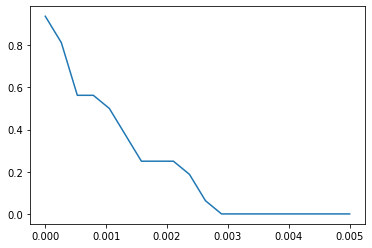

In [38]:
plt.plot(epsilons, robust_accuracy.numpy())

We can see that **the model is not robust** at all. Even extremely small perturbations (Linf norm of 0.003 for pixels between 0 and 1) are sufficient
to change the classification.

## Run a targeted attack

In [39]:
labels

PyTorchTensor(tensor([243, 559, 438, 990, 949, 853, 609, 609, 915, 455, 541, 630, 741, 471,
                      129,  99], device='cuda:0'))

In [40]:
target_classes = (labels + 200) % 1000

In [41]:
target_classes

PyTorchTensor(tensor([443, 759, 638, 190, 149,  53, 809, 809, 115, 655, 741, 830, 941, 671,
                      329, 299], device='cuda:0'))

In [42]:
criterion = fb.criteria.TargetedMisclassification(target_classes)

In [43]:
attack = fb.attacks.L2CarliniWagnerAttack(steps=100)
# Note: 100 is too little -> results will be bad = perturbations will be relatively large (but 1000 takes much longer)

In [44]:
# epsilons = np.linspace(0.0, 10.0, num=20)
epsilons = None

In [45]:
advs, _, is_adv = attack(fmodel, images, criterion, epsilons=epsilons)

In [46]:
is_adv

PyTorchTensor(tensor([True, True, True, True, True, True, True, True, True, True, True, True,
                      True, True, True, True], device='cuda:0'))

In [47]:
fb.distances.l2(images, advs)

PyTorchTensor(tensor([0.7649, 0.7219, 0.5241, 1.1482, 0.6145, 0.3800, 0.4753, 0.7821, 1.0796,
                      0.9680, 0.6295, 0.3825, 1.9305, 1.4613, 0.6005, 0.8728],
                     device='cuda:0'))

In [48]:
# attack_success_rate = is_adv.float32().mean(axis=-1)

In [49]:
# plt.plot(epsilons, attack_success_rate.numpy())

## Visualizing adversarial examples and perturbations

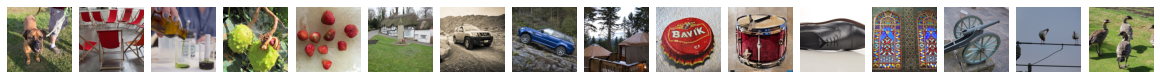

In [50]:
fb.plot.images(images)

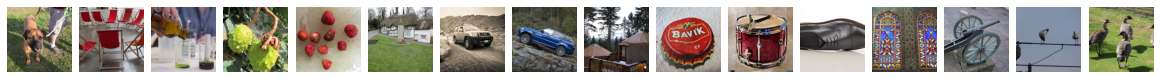

In [51]:
fb.plot.images(advs)

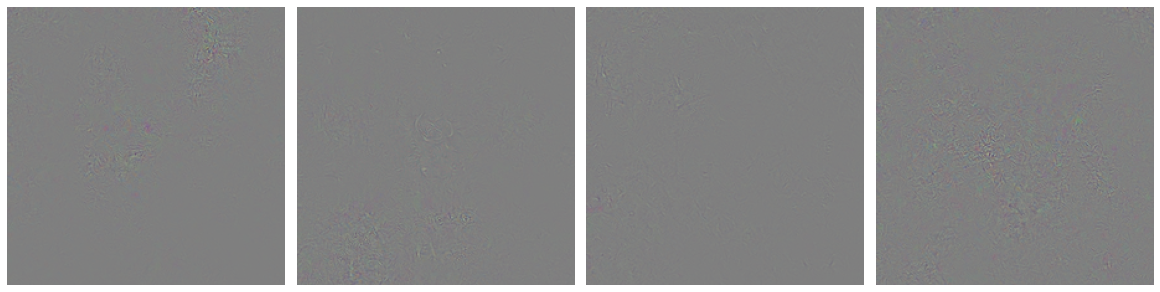

In [52]:
fb.plot.images(advs - images, n=4, bounds=(-0.1, 0.1), scale=4.)

The adversarial examples look like the orignal (clean) images. That shows that **the model is not robust against adversarial attacks**. Tiny perturbations mislead the model and allow the attacker to control which class is recognized.

## Continuing from here ...



*   Repeating an attack (`attack = attack.repeat(3)`)
*   Getting the per-sample worst-case over multiple attacks
    * stack attack results and take max over the attacks before taking the mean over samples
*   Gradient estimators (`fb.gradient_estimators.*`)
*   Transfer attacks using gradient substitution (see examples)



### Inception 3


In [53]:
batch = 10 # how many adversarial examples to find

In [54]:
# Imports
import time
import numpy as np
import torchvision.models as models
import matplotlib.pyplot as plt
%matplotlib inline

# Foolbox defaults to a GPU

In [55]:
# sets a bunch of variables - could have an if-else to mess with different networks
network = models.inception_v3(pretrained=True) # grab the model from torchvision
dataset = 'imagenet'
channels = 3 # RGB
size = 224 # image size
classes = 1000 
network.eval();

Downloading: "https://download.pytorch.org/models/inception_v3_google-0cc3c7bd.pth" to /root/.cache/torch/hub/checkpoints/inception_v3_google-0cc3c7bd.pth


In [56]:
# Foolbox time 
# Convert the model to a Foolbox model
fnetwork = fb.models.PyTorchModel(network, bounds=bounds, preprocessing=preprocessing) 

# get source image and label
# images are just an array
images, labels = fb.utils.samples(fmodel = fnetwork, dataset=dataset, batchsize=batch, data_format='channels_first', bounds=(0, 1))
images = images.reshape(batch, channels, size, size)

print(images.shape)
print("Labels:      ", labels)
#predictions = fnetwork.forward(images).argmax(axis=-1)
#print("Predictions: ", predictions) # original prediction
#print("Accuracy: ", np.mean(predictions == labels)) # Accuracy of original images
#already_correct = np.sum(predictions != labels) # keep track of how many were already correct

torch.Size([10, 3, 224, 224])
Labels:       tensor([243, 559, 438, 990, 949, 853, 609, 609, 915, 455], device='cuda:0')


In [57]:
attack = fb.attacks.LinfDeepFoolAttack()

t1 = time.time()
adversarials, _, is_advs = attack(fnetwork, images, labels, epsilons=0.03) # get the adversarial examples
t2 = time.time()

avg_time = (t2 - t1) / batch
print("Avg Time: ", avg_time, "seconds")

Avg Time:  0.404697585105896 seconds


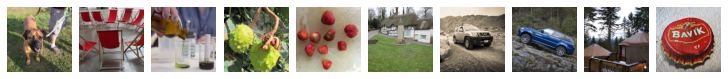

In [58]:
fb.plot.images(images)

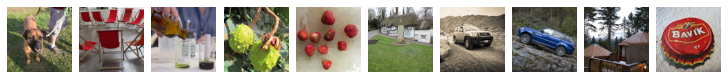

In [59]:
fb.plot.images(adversarials)

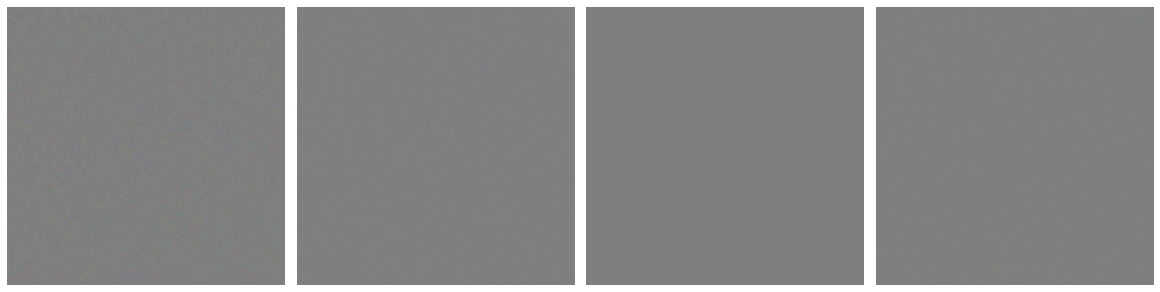

In [60]:
fb.plot.images(adversarials - images, n=4, bounds=(-0.1, 0.1), scale=4.)

### GoogleNet

In [61]:
# sets a bunch of variables - could have an if-else to mess with different networks
googlemodel = models.googlenet(pretrained=True) # grab the model from torchvision
dataset = 'imagenet'
channels = 3 # RGB
size = 224 # image size
classes = 1000 
googlemodel.eval();

Downloading: "https://download.pytorch.org/models/googlenet-1378be20.pth" to /root/.cache/torch/hub/checkpoints/googlenet-1378be20.pth


In [62]:
# Foolbox time 
# Convert the model to a Foolbox model
fmodel = fb.models.PyTorchModel(googlemodel, bounds=bounds, preprocessing=preprocessing) 

# get source image and label
# images are just an array
images, labels = fb.utils.samples(fmodel = fmodel, dataset=dataset, batchsize=batch, data_format='channels_first', bounds=(0, 1))
images = images.reshape(batch, channels, size, size)

print(images.shape)
print("Labels:      ", labels)

torch.Size([10, 3, 224, 224])
Labels:       tensor([243, 559, 438, 990, 949, 853, 609, 609, 915, 455], device='cuda:0')


In [63]:
attack = fb.attacks.LinfDeepFoolAttack()

t1 = time.time()
adversarials, _, is_advs = attack(fmodel, images, labels, epsilons=0.03) # get the adversarial examples
t2 = time.time()

avg_time = (t2 - t1) / batch
print("Avg Time: ", avg_time, "seconds")

Avg Time:  0.13463947772979737 seconds


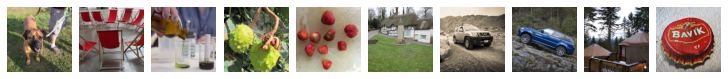

In [64]:
fb.plot.images(images)

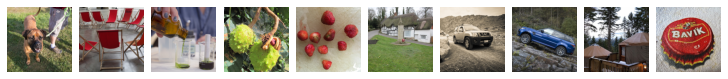

In [65]:
fb.plot.images(adversarials)

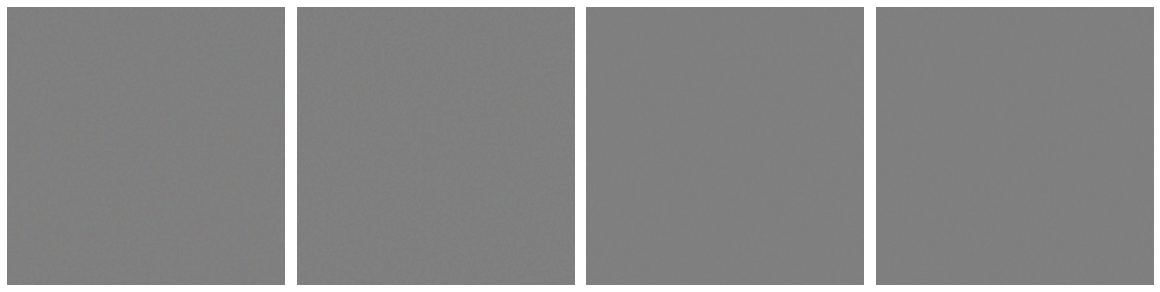

In [66]:
fb.plot.images(adversarials - images, n=4, bounds=(-0.1, 0.1), scale=4.)

### DenseNet

In [67]:
# sets a bunch of variables - could have an if-else to mess with different networks
dmodel = models.densenet121(pretrained=True) # grab the model from torchvision
dataset = 'imagenet'
channels = 3 # RGB
size = 224 # image size
classes = 1000 
dmodel.eval();

Downloading: "https://download.pytorch.org/models/densenet121-a639ec97.pth" to /root/.cache/torch/hub/checkpoints/densenet121-a639ec97.pth


In [68]:
# Foolbox time 
# Convert the model to a Foolbox model
fdmodel = fb.models.PyTorchModel(dmodel, bounds=bounds, preprocessing=preprocessing) 

# get source image and label
# images are just an array
images, labels = fb.utils.samples(fmodel = fdmodel, dataset=dataset, batchsize=batch, data_format='channels_first', bounds=(0, 1))
images = images.reshape(batch, channels, size, size)

print(images.shape)
print("Labels:      ", labels)

torch.Size([10, 3, 224, 224])
Labels:       tensor([243, 559, 438, 990, 949, 853, 609, 609, 915, 455], device='cuda:0')


In [69]:
attack = fb.attacks.LinfDeepFoolAttack()

t1 = time.time()
adversarials, _, is_advs = attack(fmodel, images, labels, epsilons=0.03) # get the adversarial examples
t2 = time.time()

avg_time = (t2 - t1) / batch
print("Avg Time: ", avg_time, "seconds")

Avg Time:  0.13867518901824952 seconds


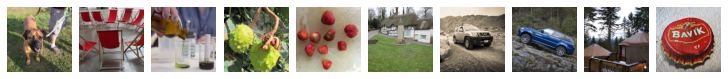

In [70]:
fb.plot.images(images)

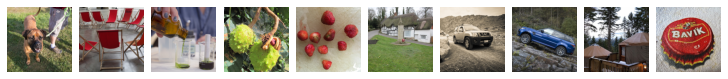

In [71]:
fb.plot.images(adversarials)

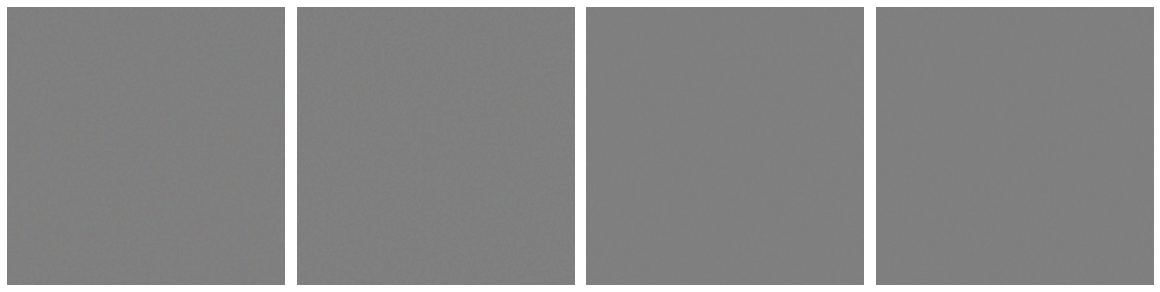

In [72]:
fb.plot.images(adversarials - images, n=4, bounds=(-0.1, 0.1), scale=4.)

###EfficientNet

In [73]:
!pip install efficientnet_pytorch

In [74]:
from efficientnet_pytorch import EfficientNet
model = EfficientNet.from_name('efficientnet-b1')

In [75]:
# Unfreeze model weights
for param in model.parameters():
    param.requires_grad = True

In [78]:
model.eval()

EfficientNet(
  (_conv_stem): Conv2dStaticSamePadding(
    3, 32, kernel_size=(3, 3), stride=(2, 2), bias=False
    (static_padding): ZeroPad2d(padding=(0, 1, 0, 1), value=0.0)
  )
  (_bn0): BatchNorm2d(32, eps=0.001, momentum=0.010000000000000009, affine=True, track_running_stats=True)
  (_blocks): ModuleList(
    (0): MBConvBlock(
      (_depthwise_conv): Conv2dStaticSamePadding(
        32, 32, kernel_size=(3, 3), stride=[1, 1], groups=32, bias=False
        (static_padding): ZeroPad2d(padding=(1, 1, 1, 1), value=0.0)
      )
      (_bn1): BatchNorm2d(32, eps=0.001, momentum=0.010000000000000009, affine=True, track_running_stats=True)
      (_se_reduce): Conv2dStaticSamePadding(
        32, 8, kernel_size=(1, 1), stride=(1, 1)
        (static_padding): Identity()
      )
      (_se_expand): Conv2dStaticSamePadding(
        8, 32, kernel_size=(1, 1), stride=(1, 1)
        (static_padding): Identity()
      )
      (_project_conv): Conv2dStaticSamePadding(
        32, 16, kernel_size=

In [79]:
# Foolbox time 
# Convert the model to a Foolbox model
femodel = fb.models.PyTorchModel(model, bounds=bounds, preprocessing=preprocessing) 

# get source image and label
# images are just an array
images, labels = fb.utils.samples(fmodel = femodel, dataset=dataset, batchsize=batch, data_format='channels_first', bounds=(0, 1))
images = images.reshape(batch, channels, size, size)

print(images.shape)
print("Labels:      ", labels)

torch.Size([10, 3, 224, 224])
Labels:       tensor([243, 559, 438, 990, 949, 853, 609, 609, 915, 455], device='cuda:0')


In [80]:
attack = fb.attacks.LinfDeepFoolAttack()

t1 = time.time()
adversarials, _, is_advs = attack(fmodel, images, labels, epsilons=0.03) # get the adversarial examples
t2 = time.time()

avg_time = (t2 - t1) / batch
print("Avg Time: ", avg_time, "seconds")

Avg Time:  0.13887457847595214 seconds


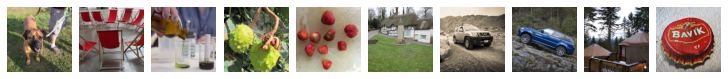

In [81]:
fb.plot.images(images)

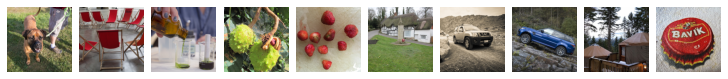

In [82]:
fb.plot.images(adversarials)

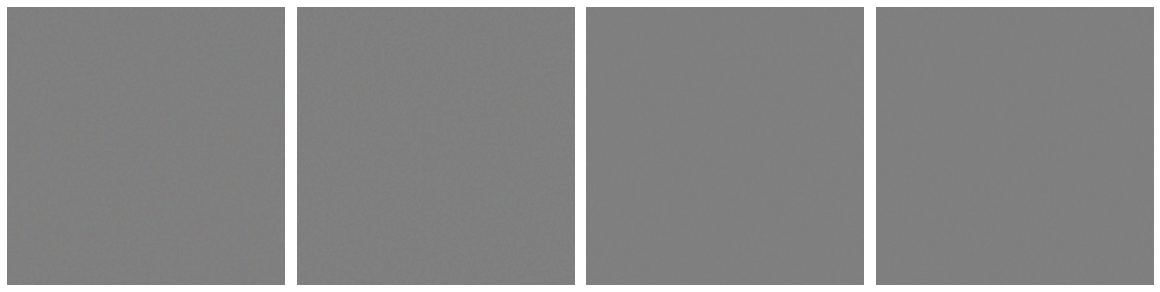

In [83]:
fb.plot.images(adversarials - images, n=4, bounds=(-0.1, 0.1), scale=4.)